In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Time Series Forecasting (End to End with codes)

## we will work on almost all available techniques including:

**1.** **Time Series analysis with pandas**

   * Working with datetime index
   * date_range to create range of dates
   * Resampling the data
   * Shifting and Rolling
   
**2.** **Time Series analysis with Statsmodels**

   * Using statsmodels to get the trend, plot the data
   * ETS Models ( Error, Trend, Seasonality)
   * Seasonal Decomposition
   * Moving Averages- Simple Moving Averages, Holten winters method, Exponential moving averages,    Simple exponential smoothing, Double exponential smooting.
   
**3.** **General forecasting models**

   * Forecasting with holt winters method
   * Stationarity
   * Differencing
   * Autocorrelation ACF, PACF
   * Augmented Dickey-Fuller Test
   
**4. Introduction to ARIMA models**

   * Choosing ARIMA orders, auto_arima (pmdarima)
   * ARIMA
   * SARIMA
   * Model building and predictions
   * plotting


# 1.Time Series with Pandas

### 1.1 Datetime Index

In [ ]:
import numpy as np
from datetime import datetime
from IPython.display import Image

### 1.2 how to get a series of dates with numpy

In [ ]:
dates=np.arange('2020-01-01', '2020-01-31',  dtype='datetime64[D]')
dates

As seen above, arange gave us all the days between start and end dates

we can also add "step size" to give us only the desired dates after each step size. 10 is number of days as "D" is mentioned in datetime type

In [ ]:
dates=np.arange('2020-01-01', '2020-01-31', 10, dtype='datetime64[D]')
dates

### 1.3 pandas date_range 

In [ ]:
import pandas as pd
dates=pd.date_range('2020-01-01', periods=7, freq='D')
dates

It also gave similar results and we only had to specify start date, with periods and frequency.

### 1.4 Time Resampling

In [ ]:
data=pd.read_csv('../input/starbucks/starbucks.csv')
data.head()

In [ ]:
data.info()

### we can see above that 'Date' column is not a datetime object. we can use 2 methods to make it a date column.
1. Either during importing, we set parse_dates=True and index_col='Date'
2. set index of the dataframe to 'Date' and convert 'Date' to datetime object using pandas to_datetime

In [ ]:
data['Date']=pd.to_datetime(data['Date'])

In [ ]:
data.info()

See, now 'Date' column has been converted to datetime object. Now let's set this column as index

In [ ]:
data=data.set_index('Date')
data.head()

In [ ]:
data.index

This is a daily data as you can see from dates. However, we can use resampling to convert into weekly, monthly or yearly as per our requirement

In [ ]:
# daily to yearly
data.resample('A').mean()

In [ ]:
data.head()

In [ ]:
# Let's resample only a series column and plot it

data['Close'].resample('A').mean().plot(kind='bar')

### Below are the aliases which you can use while resampling
for example "A" means resample to yearly

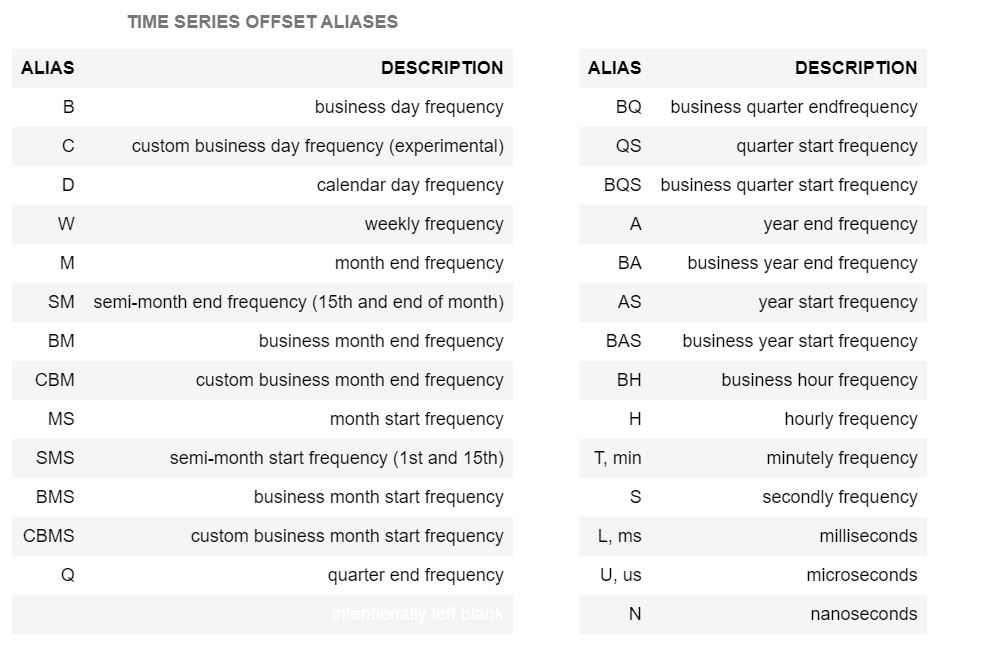

### 1.4 Shifting and rolling

### Shifting

In [ ]:
# shifting means time shifting the whole dataframe or a particular series by 1 up or down

data.head()

In [ ]:
data.shift(1)

data has been shifted downwards. Hence, first row becomes blank and last row gets pruned. Similarly shift(-1) will shift the data upwards

## Rolling

We can create a rolling mean dataframe or series using rolling method. We need to specify the window size and mean will be created according to the window size. For ex: window size of 6 means, it will take the first 6 samples and create a mean value and them move from second sample to next 6 and so on

In [ ]:
data.rolling(window=3).mean().head()
# Notice that first 2 values are NAN hence sampling mean of 3 samples will start only from the 3rd sample

In [ ]:
data['Close'].plot(figsize=(12,5))
data['Close'].rolling(window=30).mean().plot()

we can also limit the data before plotting if we want to focus only towards a particular interval. Let's see below

### Choosing X limits by Slice

In [ ]:
# here we only focus on the plot containing the data from 2016-2017. we can also limit the data in the plot itself using xlim and ylim but i suggest to limit the data before plotting
data['Close']['2016-01-01':'2017-12-31'].plot(figsize=(12,5), ls='--', color='red')


### Choosing X limits by Slice

In [ ]:
# Dates are separated by a comma:
data['Close'].plot(figsize=(12,4),xlim=['2017-01-01','2017-03-01']);

# 2.Time Series analysis with Statsmodels

#### Introduction to Statsmodels
Statsmodels is a Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration. An extensive list of result statistics are available for each estimator. The results are tested against existing statistical packages to ensure that they are correct. The package is released under the open source Modified BSD (3-clause) license. The online documentation is hosted at statsmodels.org. The statsmodels version used in the development of this course is 0.9.0.

### Statsmodels 

In [ ]:
df = pd.read_csv('../input/macrodata/macrodata.csv',index_col=0,parse_dates=True)
df.head()

### Plot the data

In [ ]:
ax = df['realgdp'].plot()
ax.autoscale(axis='x',tight=True)
ax.set(ylabel='REAL GDP');

### 2.1 Using statsmodels to get the trend

The Hodrick-Prescott filter separates a time-series  𝑦𝑡  into a trend component  𝜏𝑡  and a cyclical component  𝑐𝑡 
𝑦𝑡=𝜏𝑡+𝑐𝑡 
The components are determined by minimizing the following quadratic loss function, where  𝜆  is a smoothing parameter:

min𝜏𝑡∑𝑇𝑡=1𝑐2𝑡+𝜆∑𝑇𝑡=1[(𝜏𝑡−𝜏𝑡−1)−(𝜏𝑡−1−𝜏𝑡−2)]2 
The  𝜆  value above handles variations in the growth rate of the trend component.
When analyzing quarterly data, the default lambda value of 1600 is recommended. Use 6.25 for annual data, and 129,600 for monthly data.

In [ ]:
from statsmodels.tsa.filters.hp_filter import hpfilter

# Tuple unpacking
gdp_cycle, gdp_trend = hpfilter(df['realgdp'], lamb=1600)

In [ ]:
df['trend'] = gdp_trend
df[['trend','realgdp']].plot().autoscale(axis='x',tight=True);

In [ ]:
df[['trend','realgdp']]['2000-03-31':].plot(figsize=(12,8)).autoscale(axis='x',tight=True);

### ETS

### 2.2 ETS Models ( Error, Trend, Seasonality)
* Exponential smooting
* Trend methods models
* ETS Decomposition

As we begin working with endogenous data ("endog" for short) and start to develop forecasting models, it helps to identify and isolate factors working within the system that influence behavior. Here the name "endogenous" considers internal factors, while "exogenous" would relate to external forces. These fall under the category of state space models, and include decomposition (described below), and exponential smoothing (described in an upcoming section).

The decomposition of a time series attempts to isolate individual components such as error, trend, and seasonality (ETS). We've already seen a simplistic example of this in the Introduction to Statsmodels section with the Hodrick-Prescott filter. There we separated data into a trendline and a cyclical feature that mapped observed data back to the trend.

### 2.3 Seasonal Decomposition
Statsmodels provides a <em>seasonal decomposition</em> tool we can use to separate out the different components. This lets us see quickly and visually what each component contributes to the overall behavior.


We apply an <strong>additive</strong> model when it seems that the trend is more linear and the seasonality and trend components seem to be constant over time (e.g. every year we add 10,000 passengers).<br>
A <strong>multiplicative</strong> model is more appropriate when we are increasing (or decreasing) at a non-linear rate (e.g. each year we double the amount of passengers).

For these examples we'll use the International Airline Passengers dataset, which gives monthly totals in thousands from January 1949 to December 1960.

In [ ]:
airline = pd.read_csv('../input/airline/airline_passengers.csv',index_col='Month',parse_dates=True)
airline.dropna(inplace=True)
airline.head()

In [ ]:
airline.plot();

Based on this chart, it looks like the trend in the earlier days is increasing at a higher rate than just linear (although it is a  bit hard to tell from this one plot).

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(airline['Thousands of Passengers'], model='multiplicative')  # model='mul' also works
result.plot();

we can see the trend clearly going upwards. Also huge seasonality component involved. 

### 2.4 Moving Averages

### Simple Moving Average

In [ ]:
airline['6-month-SMA'] = airline['Thousands of Passengers'].rolling(window=6).mean()
airline['12-month-SMA'] = airline['Thousands of Passengers'].rolling(window=12).mean()
airline.head(15)

In [ ]:
airline.plot();

### Exponentially moving Average

We just showed how to calculate the SMA based on some window. However, basic SMA has some weaknesses:
* Smaller windows will lead to more noise, rather than signal
* It will always lag by the size of the window
* It will never reach to full peak or valley of the data due to the averaging.
* Does not really inform you about possible future behavior, all it really does is describe trends in your data.
* Extreme historical values can skew your SMA significantly

To help fix some of these issues, we can use an <a href='https://en.wikipedia.org/wiki/Exponential_smoothing'>EWMA (Exponentially weighted moving average)</a>.

EWMA will allow us to reduce the lag effect from SMA and it will put more weight on values that occured more recently (by applying more weight to the more recent values, thus the name). The amount of weight applied to the most recent values will depend on the actual parameters used in the EWMA and the number of periods given a window size.
[Full details on Mathematics behind this can be found here](http://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html#exponentially-weighted-windows).
Here is the shorter version of the explanation behind EWMA.

The formula for EWMA is:
### $y_t =   \frac{\sum\limits_{i=0}^t w_i x_{t-i}}{\sum\limits_{i=0}^t w_i}$

Where $x_t$ is the input value, $w_i$ is the applied weight (Note how it can change from $i=0$ to $t$), and $y_t$ is the output.

Now the question is, how to we define the weight term $w_i$?

This depends on the <tt>adjust</tt> parameter you provide to the <tt>.ewm()</tt> method.

When <tt>adjust=True</tt> (default) is used, weighted averages are calculated using weights equal to $w_i = (1 - \alpha)^i$

which gives

### $y_t = \frac{x_t + (1 - \alpha)x_{t-1} + (1 - \alpha)^2 x_{t-2} + ...
+ (1 - \alpha)^t x_{0}}{1 + (1 - \alpha) + (1 - \alpha)^2 + ...
+ (1 - \alpha)^t}$

When <tt>adjust=False</tt> is specified, moving averages are calculated as:

### $\begin{split}y_0 &= x_0 \\
y_t &= (1 - \alpha) y_{t-1} + \alpha x_t,\end{split}$

which is equivalent to using weights:

 \begin{split}w_i = \begin{cases}
    \alpha (1 - \alpha)^i & \text{if } i < t \\
    (1 - \alpha)^i        & \text{if } i = t.
\end{cases}\end{split}

When <tt>adjust=True</tt> we have $y_0=x_0$ and from the last representation above we have 
$y_t=\alpha x_t+(1−α)y_{t−1}$, therefore there is an assumption that $x_0$ is not an ordinary value but rather an exponentially weighted moment of the infinite series up to that point.

For the smoothing factor $\alpha$ one must have $0<\alpha≤1$, and while it is possible to pass <em>alpha</em> directly, it’s often easier to think about either the <em>span</em>, <em>center of mass</em> (com) or <em>half-life</em> of an EW moment:

:

\begin{split}\alpha =
 \begin{cases}
     \frac{2}{s + 1},               & \text{for span}\ s \geq 1\\
     \frac{1}{1 + c},               & \text{for center of mass}\ c \geq 0\\
     1 - \exp^{\frac{\log 0.5}{h}}, & \text{for half-life}\ h > 0
 \end{cases}\end{split}


* <strong>Span</strong> corresponds to what is commonly called an “N-day EW moving average”.
* <strong>Center of mass</strong> has a more physical interpretation and can be thought of in terms of span: $c=(s−1)/2$
* <strong>Half-life</strong> is the period of time for the exponential weight to reduce to one half.
* <strong>Alpha</strong> specifies the smoothing factor directly.

We have to pass precisely one of the above into the <tt>.ewm()</tt> function. For our data we'll use <tt>span=12</tt>.

In [ ]:
airline['EWMA12'] = airline['Thousands of Passengers'].ewm(span=12,adjust=False).mean()

In [ ]:
airline[['Thousands of Passengers','EWMA12']].plot();

### Comparing SMA to EWMA

In [ ]:
airline[['Thousands of Passengers','EWMA12','12-month-SMA']].plot(figsize=(12,8)).autoscale(axis='x',tight=True);

### Simple Exponential Smoothing
The above example employed <em>Simple Exponential Smoothing</em> with one smoothing factor <strong>α</strong>. Unfortunately, this technique does a poor job of forecasting when there is a trend in the data as seen above

### Holt-Winters Methods
we discussed  on <strong>Exponentially Weighted Moving Averages</strong> (EWMA) we applied <em>Simple Exponential Smoothing</em> using just one smoothing factor $\alpha$ (alpha). This failed to account for other contributing factors like trend and seasonality.

Now, we'll look at <em>Double</em> and <em>Triple Exponential Smoothing</em> with the <a href='https://otexts.com/fpp2/holt-winters.html'>Holt-Winters Methods</a>. 

In <strong>Double Exponential Smoothing</strong> (aka Holt's Method) we introduce a new smoothing factor $\beta$ (beta) that addresses trend:

\begin{split}l_t &= (1 - \alpha) l_{t-1} + \alpha x_t, & \text{    level}\\
b_t &= (1-\beta)b_{t-1} + \beta(l_t-l_{t-1}) & \text{    trend}\\
y_t &= l_t + b_t & \text{    fitted model}\\
\hat y_{t+h} &= l_t + hb_t & \text{    forecasting model (} h = \text{# periods into the future)}\end{split}

Because we haven't yet considered seasonal fluctuations, the forecasting model is simply a straight sloped line extending from the most recent data point. We'll see an example of this in upcoming lectures.

With <strong>Triple Exponential Smoothing</strong> (aka the Holt-Winters Method) we introduce a smoothing factor $\gamma$ (gamma) that addresses seasonality:

\begin{split}l_t &= (1 - \alpha) l_{t-1} + \alpha x_t, & \text{    level}\\
b_t &= (1-\beta)b_{t-1} + \beta(l_t-l_{t-1}) & \text{    trend}\\
c_t &= (1-\gamma)c_{t-L} + \gamma(x_t-l_{t-1}-b_{t-1}) & \text{    seasonal}\\
y_t &= (l_t + b_t) c_t & \text{    fitted model}\\
\hat y_{t+m} &= (l_t + mb_t)c_{t-L+1+(m-1)modL} & \text{    forecasting model (} m = \text{# periods into the future)}\end{split}

Here $L$ represents the number of divisions per cycle. In our case looking at monthly data that displays a repeating pattern each year, we would use $L=12$.

In general, higher values for $\alpha$, $\beta$ and $\gamma$ (values closer to 1), place more emphasis on recent data.

<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.SimpleExpSmoothing.html'>statsmodels.tsa.holtwinters.SimpleExpSmoothing</a></strong><font color=black>(endog)</font>&nbsp;&nbsp;&nbsp;&nbsp;
Simple Exponential Smoothing<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html'>statsmodels.tsa.holtwinters.ExponentialSmoothing</a></strong><font color=black>(endog)</font>&nbsp;&nbsp;
    Holt-Winters Exponential Smoothing</tt>
    
<h3>For Further Reading:</h3>
<tt>
<strong>
<a href='https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc43.htm'>NIST/SEMATECH e-Handbook of Statistical Methods</a></strong>&nbsp;&nbsp;<font color=black>What is Exponential Smoothing?</font></tt></div>

In [ ]:
df = pd.read_csv('../input/airline/airline_passengers.csv',index_col='Month',parse_dates=True)
df.dropna(inplace=True)
df.index

### Setting a DatetimeIndex Frequency
Note that our DatetimeIndex does not have a frequency. In order to build a Holt-Winters smoothing model, statsmodels needs to know the frequency of the data (whether it's daily, monthly etc.). Since observations occur at the start of each month, we'll use MS.<br>A full list of time series offset aliases can be found <a href='http://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases'>here</a>.

In [ ]:
df.index.freq = 'MS'
df.index

___
### Simple Exponential Smoothing

A variation of the statmodels Holt-Winters function provides Simple Exponential Smoothing. It will be shown that it performs the same calculation of the weighted moving average as the pandas <tt>.ewm()</tt> method:<br>
$\begin{split}y_0 &= x_0 \\
y_t &= (1 - \alpha) y_{t-1} + \alpha x_t,\end{split}$

In [ ]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

span = 12
alpha = 2/(span+1)

df['EWMA12'] = df['Thousands of Passengers'].ewm(alpha=alpha,adjust=False).mean()
df['SES12']=SimpleExpSmoothing(df['Thousands of Passengers']).fit(smoothing_level=alpha,optimized=False).fittedvalues.shift(-1)
df.head()

___
### Double Exponential Smoothing
Where Simple Exponential Smoothing employs just one smoothing factor $\alpha$ (alpha), Double Exponential Smoothing adds a second smoothing factor $\beta$ (beta) that addresses trends in the data. Like the alpha factor, values for the beta factor fall between zero and one ($0<\beta≤1$). The benefit here is that the model can anticipate future increases or decreases where the level model would only work from recent calculations.

We can also address different types of change (growth/decay) in the trend. If a time series displays a straight-line sloped trend, you would use an <strong>additive</strong> adjustment. If the time series displays an exponential (curved) trend, you would use a <strong>multiplicative</strong> adjustment.

As we move toward forecasting, it's worth noting that both additive and multiplicative adjustments may become exaggerated over time, and require <em>damping</em> that reduces the size of the trend over future periods until it reaches a flat line.

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

df['DESadd12'] = ExponentialSmoothing(df['Thousands of Passengers'], trend='add').fit().fittedvalues.shift(-1)
df.head()

In [ ]:
df[['Thousands of Passengers','EWMA12','DESadd12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

Here we can see that Double Exponential Smoothing is a much better representation of the time series data.
Let's see if using a multiplicative seasonal adjustment helps.

In [ ]:
df['DESmul12'] = ExponentialSmoothing(df['Thousands of Passengers'], trend='mul').fit().fittedvalues.shift(-1)
df.head()

In [ ]:
df[['Thousands of Passengers','DESadd12','DESmul12']].iloc[:24].plot(figsize=(12,6)).autoscale(axis='x',tight=True);

Although minor, it does appear that a multiplicative adjustment gives better results. Note that the green line almost completely overlaps the original data

# 3. General Forecasting models 

### Forecasting with Holt-Winters method

In [ ]:
df = pd.read_csv('../input/airline/airline_passengers.csv',index_col='Month',parse_dates=True)
df.index.freq = 'MS'
df.head()

#### Train Test split

In [ ]:
train_data = df.iloc[:109] # Goes up to but not including 109
test_data = df.iloc[108:]

#### Fitting the model
    

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

fitted_model=ExponentialSmoothing(train_data['Thousands of Passengers'], trend='mul', seasonal='mul', seasonal_periods=12).fit()

In [ ]:
# Let's do the forecast. Ignore the warings as it is related to statsmodels
predictions=fitted_model.forecast(36).rename("Forecast")
predictions

In [ ]:
train_data['Thousands of Passengers'].plot(legend=True, label="TRAIN DATA")
test_data['Thousands of Passengers'].plot(legend=True, label="TEST DATA", figsize=(12,8))
predictions.plot(legend=True, label='PREDICTIONS')

In [ ]:
train_data['Thousands of Passengers'].plot(legend=True,label='TRAIN')
test_data['Thousands of Passengers'].plot(legend=True,label='TEST',figsize=(12,8))
predictions.plot(legend=True,label='PREDICTION',xlim=['1958-01-01','1961-01-01'])

### Evaluating predictions

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

In [ ]:
mean_absolute_error(test_data,predictions)

In [ ]:
np.sqrt(mean_squared_error(test_data,predictions))

## Stationarity

Time series data is said to be <em>stationary</em> if it does <em>not</em> exhibit trends or seasonality. That is, fluctuations in the data are entirely due to outside forces and noise. The file <tt>samples.csv</tt> contains made-up datasets that illustrate stationary and non-stationary data.

****Stationary Vs Non Stationary****

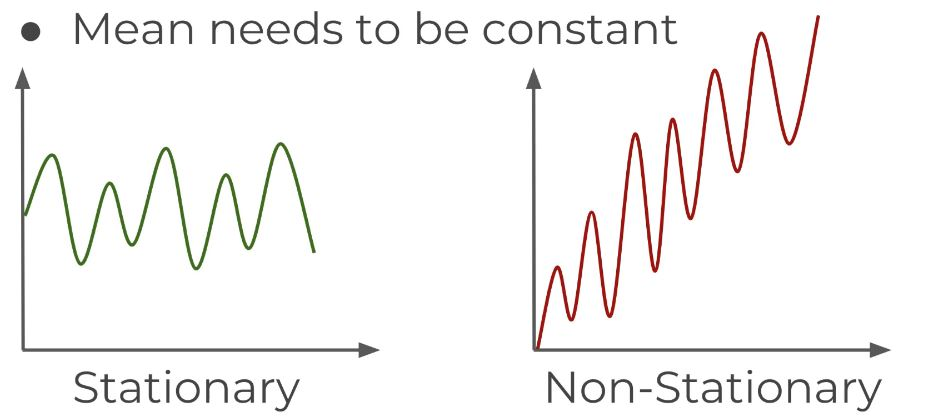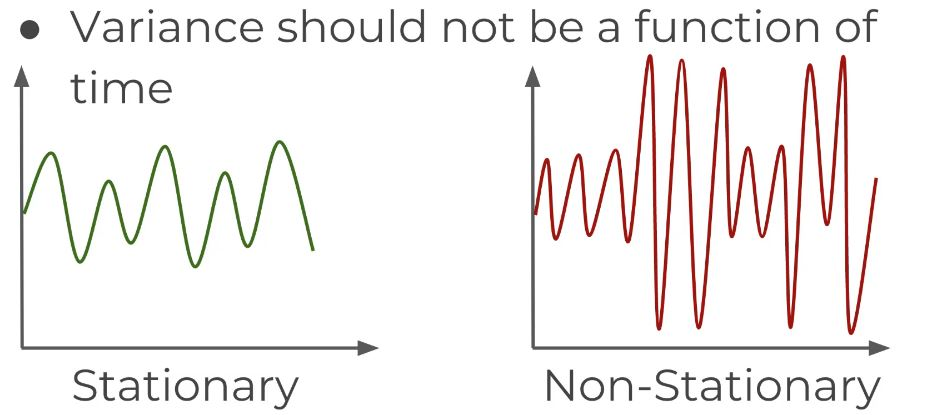

In [ ]:
df2 = pd.read_csv('../input/samples/samples.csv',index_col=0,parse_dates=True)
df2.head()

In [ ]:
df2['a'].plot(ylim=[0,100],title="STATIONARY DATA").autoscale(axis='x',tight=True);

In [ ]:
df2['b'].plot(ylim=[0,100],title="NON-STATIONARY DATA").autoscale(axis='x',tight=True);

## Differencing
Non-stationary data can be made to look stationary through <em>differencing</em>. A simple differencing method calculates the difference between consecutive points.

<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.tools.diff.html'>statespace.tools.diff</a></strong><font color=black>(series[, k_diff, …])</font>&nbsp;&nbsp;Difference a series simply and/or seasonally along the zero-th axis.</tt></div>

In [ ]:
from statsmodels.tsa.statespace.tools import diff
df2['d1'] = diff(df2['b'],k_diff=1)

df2['d1'].plot(title="FIRST DIFFERENCE DATA").autoscale(axis='x',tight=True);

## ACF and PACF
## Autocorrelation Function / Partial Autocorrelation Function
Before we can investigate <em>autoregression</em> as a modeling tool, we need to look at <em>covariance</em> and <em>correlation</em> as they relate to lagged (shifted) samples of a time series.


#### Goals
 * Be able to create ACF and PACF charts
 * Create these charts for multiple times series, one with seasonality and another without
 * Be able to calculate Orders PQD terms for ARIMA off these charts (highlight where they cross the x axis)
 
<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.acovf.html'>stattools.acovf</a></strong><font color=black>(x[, unbiased, demean, fft, …])</font>&nbsp;Autocovariance for 1D<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.acf.html'>stattools.acf</a></strong><font color=black>(x[, unbiased, nlags, qstat, …])</font>&nbsp;&nbsp;Autocorrelation function for 1d arrays<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.pacf.html'>stattools.pacf</a></strong><font color=black>(x[, nlags, method, alpha])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Partial autocorrelation estimated<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.pacf_yw.html'>stattools.pacf_yw</a></strong><font color=black>(x[, nlags, method])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Partial autocorrelation estimated with non-recursive yule_walker<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.pacf_ols.html'>stattools.pacf_ols</a></strong><font color=black>(x[, nlags])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Calculate partial autocorrelations</tt>
   
<h3>Related Plot Methods:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html'>tsaplots.plot_acf</a></strong><font color=black>(x)</font>&nbsp;&nbsp;&nbsp;Plot the autocorrelation function<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html'>tsaplots.plot_pacf</a></strong><font color=black>(x)</font>&nbsp;&nbsp;Plot the partial autocorrelation function</tt>

<h3>For Further Reading:</h3>
<strong>
<a href='https://en.wikipedia.org/wiki/Autocovariance'>Wikipedia:</a></strong>&nbsp;&nbsp;<font color=black>Autocovariance</font><br>
<strong>
<a href='https://otexts.com/fpp2/autocorrelation.html'>Forecasting: Principles and Practice</a></strong>&nbsp;&nbsp;<font color=black>Autocorrelation</font><br>
<strong>
<a href='https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc4463.htm'>NIST Statistics Handbook</a></strong>&nbsp;&nbsp;<font color=black>Partial Autocorrelation Plot</font></div>


In [ ]:

# Load a non-stationary dataset
df1 = pd.read_csv('../input/airline/airline_passengers.csv',index_col='Month',parse_dates=True)
df1.index.freq = 'MS'

# Load a stationary dataset
df2 = pd.read_csv('../input/dailytotalfemalebirths/DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df2.index.freq = 'D'

In [ ]:
# Import the models
from statsmodels.tsa.stattools import acovf,acf,pacf,pacf_yw,pacf_ols

In [ ]:
#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Autocovariance for 1D
In a <em>deterministic</em> process, like $y=sin(x)$, we always know the value of $y$ for a given value of $x$. However, in a <em>stochastic</em> process there is always some randomness that prevents us from knowing the value of $y$. Instead, we analyze the past (or <em>lagged</em>) behavior of the system to derive a probabilistic estimate for $\hat{y}$.

One useful descriptor is <em>covariance</em>. When talking about dependent and independent $x$ and $y$ variables, covariance describes how the variance in $x$ relates to the variance in $y$. Here the size of the covariance isn't really important, as $x$ and $y$ may have very different scales. However, if the covariance is positive it means that $x$ and $y$ are changing in the same direction, and may be related.

With a time series, $x$ is a fixed interval. Here we want to look at the variance of $y_t$ against lagged or shifted values of $y_{t+k}$

For a stationary time series, the autocovariance function for $\gamma$ (gamma) is given as:

${\displaystyle {\gamma}_{XX}(t_{1},t_{2})=\operatorname {Cov} \left[X_{t_{1}},X_{t_{2}}\right]=\operatorname {E} [(X_{t_{1}}-\mu _{t_{1}})(X_{t_{2}}-\mu _{t_{2}})]}$

We can calculate a specific $\gamma_k$ with:

${\displaystyle \gamma_k = \frac 1 n \sum\limits_{t=1}^{n-k} (y_t - \bar{y})(y_{t+k}-\bar{y})}$

### Autocovariance Example:
Say we have a time series with five observations: {13, 5, 11, 12, 9}.<br>
We can quickly see that $n = 5$, the mean $\bar{y} = 10$, and we'll see that the variance $\sigma^2 = 8$.<br>
The following calculations give us our covariance values:
<br><br>
$\gamma_0 = \frac {(13-10)(13-10)+(5-10)(5-10)+(11-10)(11-10)+(12-10)(12-10)+(9-10)(9-10)} 5 = \frac {40} 5 = 8.0 \\
\gamma_1 = \frac {(13-10)(5-10)+(5-10)(11-10)+(11-10)(12-10)+(12-10)(9-10)} 5 = \frac {-20} 5 = -4.0 \\
\gamma_2 = \frac {(13-10)(11-10)+(5-10)(12-10)+(11-10)(9-10)} 5 = \frac {-8} 5 = -1.6 \\
\gamma_3 = \frac {(13-10)(12-10)+(5-10)(9-10)} 5 = \frac {11} 5 = 2.2 \\
\gamma_4 = \frac {(13-10)(9-10)} 5 = \frac {-3} 5 = -0.6$
<br><br>
Note that $\gamma_0$ is just the population variance $\sigma^2$

Let's see if statsmodels gives us the same results! For this we'll create a <strong>fake</strong> dataset:

In [ ]:
df = pd.DataFrame({'a':[13, 5, 11, 12, 9]})
arr = acovf(df['a'])
arr

### Unbiased Autocovariance
Note that the number of terms in the calculations above are decreasing.<br>Statsmodels can return an "unbiased" autocovariance where instead of dividing by $n$ we divide by $n-k$.

$\gamma_0 = \frac {(13-10)(13-10)+(5-10)(5-10)+(11-10)(11-10)+(12-10)(12-10)+(9-10)(9-10)} {5-0} = \frac {40} 5 = 8.0 \\
\gamma_1 = \frac {(13-10)(5-10)+(5-10)(11-10)+(11-10)(12-10)+(12-10)(9-10)} {5-1} = \frac {-20} 4 = -5.0 \\
\gamma_2 = \frac {(13-10)(11-10)+(5-10)(12-10)+(11-10)(9-10)} {5-2} = \frac {-8} 3 = -2.67 \\
\gamma_3 = \frac {(13-10)(12-10)+(5-10)(9-10)} {5-3} = \frac {11} 2 = 5.5 \\
\gamma_4 = \frac {(13-10)(9-10)} {5-4} = \frac {-3} 1 = -3.0$

In [ ]:
arr2 = acovf(df['a'],unbiased=True)
arr2

## Autocorrelation for 1D
The correlation $\rho$ (rho) between two variables $y_1,y_2$ is given as:

### $\rho = \frac {\operatorname E[(y_1−\mu_1)(y_2−\mu_2)]} {\sigma_{1}\sigma_{2}} = \frac {\operatorname {Cov} (y_1,y_2)} {\sigma_{1}\sigma_{2}}$,

where $E$ is the expectation operator, $\mu_{1},\sigma_{1}$ and $\mu_{2},\sigma_{2}$ are the means and standard deviations of $y_1$ and $y_2$.

When working with a single variable (i.e. <em>autocorrelation</em>) we would consider $y_1$ to be the original series and $y_2$ a lagged version of it. Note that with autocorrelation we work with $\bar y$, that is, the full population mean, and <em>not</em> the means of the reduced set of lagged factors (see note below).

Thus, the formula for $\rho_k$ for a time series at lag $k$ is:

${\displaystyle \rho_k = \frac {\sum\limits_{t=1}^{n-k} (y_t - \bar{y})(y_{t+k}-\bar{y})} {\sum\limits_{t=1}^{n} (y_t - \bar{y})^2}}$

This can be written in terms of the covariance constant $\gamma_k$ as:

${\displaystyle \rho_k = \frac {\gamma_k n} {\gamma_0 n} = \frac {\gamma_k} {\sigma^2}}$

For example,<br>
$\rho_4 = \frac {\gamma_4} {\sigma^2} = \frac{-0.6} {8} = -0.075$

Note that ACF values are bound by -1 and 1. That is, ${\displaystyle -1 \leq \rho_k \leq 1}$

In [ ]:
arr3 = acf(df['a'])
arr3

## Partial Autocorrelation
Partial autocorrelations measure the linear dependence of one variable after removing the effect of other variable(s) that affect both variables. That is, the partial autocorrelation at lag $k$ is the autocorrelation between $y_t$ and $y_{t+k}$ that is not accounted for by lags $1$ through $k−1$.

A common method employs the non-recursive <a href='https://en.wikipedia.org/wiki/Autoregressive_model#Calculation_of_the_AR_parameters'>Yule-Walker Equations</a>:

$\phi_0 = 1\\
\phi_1 = \rho_1 = -0.50\\
\phi_2 = \frac {\rho_2 - {\rho_1}^2} {1-{\rho_1}^2} = \frac {(-0.20) - {(-0.50)}^2} {1-{(-0.50)}^2}= \frac {-0.45} {0.75} = -0.60$

As $k$ increases, we can solve for $\phi_k$ using matrix algebra and the <a href='https://en.wikipedia.org/wiki/Levinson_recursion'>Levinson–Durbin recursion</a> algorithm which maps the sample autocorrelations $\rho$ to a <a href='https://en.wikipedia.org/wiki/Toeplitz_matrix'>Toeplitz</a> diagonal-constant matrix. The full solution is beyond the scope of this course, but the setup is as follows:


$\displaystyle \begin{pmatrix}\rho_0&\rho_1&\cdots &\rho_{k-1}\\
\rho_1&\rho_0&\cdots &\rho_{k-2}\\
\vdots &\vdots &\ddots &\vdots \\
\rho_{k-1}&\rho_{k-2}&\cdots &\rho_0\\
\end{pmatrix}\quad \begin{pmatrix}\phi_{k1}\\\phi_{k2}\\\vdots\\\phi_{kk}\end{pmatrix}
\mathbf = \begin{pmatrix}\rho_1\\\rho_2\\\vdots\\\rho_k\end{pmatrix}$

In [ ]:
arr4 = pacf_yw(df['a'],nlags=4,method='mle')
arr4

In [ ]:
arr5 = pacf_yw(df['a'],nlags=4,method='unbiased')
arr5

## Plotting

In [ ]:
from pandas.plotting import lag_plot

lag_plot(df1['Thousands of Passengers']);

Clearly there is a strong correlation between y and it's lagged values. hence it is not stationary

In [ ]:
lag_plot(df2['Births']);

There is little evidence of autocorrelation here.

## ACF plots

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [ ]:
# Let's look first at the ACF array. By default acf() returns 40 lags
acf(df2['Births'])

In [ ]:
# Now let's plot the autocorrelation at different lags
title = 'Autocorrelation: Daily Female Births'
lags = 40
plot_acf(df2,title=title,lags=lags);

This is a typical ACF plot for stationary data, with lags on the horizontal axis and correlations on the vertical axis. The first value $y_0$ is always 1. A sharp dropoff indicates that there is no AR component in the ARIMA model.

Next we'll look at non-stationary data with the <strong>Airline Passengers</strong> dataset:

In [ ]:
acf(df1['Thousands of Passengers'])

In [ ]:
title = 'Autocorrelation: Airline Passengers'
lags = 40
plot_acf(df1,title=title,lags=lags);

Non stationary data as there are no. of lags before ACF values drop off

### Tests for Stationarity
A time series is <em>stationary</em> if the mean and variance are fixed between any two equidistant points. That is, no matter where you take your observations, the results should be the same. A times series that shows seasonality is <em>not</em> stationary.

A test for stationarity usually involves a <a href='https://en.wikipedia.org/wiki/Unit_root_test'>unit root</a> hypothesis test, where the null hypothesis $H_0$ is that the series is <em>nonstationary</em>, and contains a unit root. The alternate hypothesis $H_1$ supports stationarity. The <a href='https://en.wikipedia.org/wiki/Augmented_Dickey-Fuller_test'>augmented Dickey-Fuller</a> and <a href='https://en.wikipedia.org/wiki/KPSS_test'>Kwiatkowski-Phillips-Schmidt-Shin</a> tests are stationarity tests. 

### Augmented Dickey-Fuller Test
To determine whether a series is stationary we can use the <a href='https://en.wikipedia.org/wiki/Augmented_Dickey-Fuller_test'>augmented Dickey-Fuller Test</a>. In this test the null hypothesis states that $\phi = 1$ (this is also called a unit test). The test returns several statistics we'll see in a moment. Our focus is on the p-value. A small p-value ($p<0.05$) indicates strong evidence against the null hypothesis.

To demonstrate, we'll use a dataset we know is <em>not</em> stationary, the airline_passenger dataset. First, let's plot the data along with a 12-month rolling mean and standard deviation:

In [ ]:
# Load a seasonal dataset
df1 = pd.read_csv('../input/airline/airline_passengers.csv',index_col='Month',parse_dates=True)
df1.index.freq = 'MS'

# Load a nonseasonal dataset
df2 = pd.read_csv('../input/dailytotalfemalebirths/DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df2.index.freq = 'D'

In [ ]:
df1['12-month-SMA'] = df1['Thousands of Passengers'].rolling(window=12).mean()
df1['12-month-Std'] = df1['Thousands of Passengers'].rolling(window=12).std()

df1[['Thousands of Passengers','12-month-SMA','12-month-Std']].plot();

In [ ]:
from statsmodels.tsa.stattools import adfuller
print('Augmented Dickey-Fuller Test on Airline Data')
dftest = adfuller(df1['Thousands of Passengers'],autolag='AIC')
dftest

In [ ]:
help(adfuller)

In [ ]:
print('Augmented Dickey-Fuller Test on Airline Data')

dfout = pd.Series(dftest[0:4],index=['ADF test statistic','p-value','# lags used','# observations'])

for key,val in dftest[4].items():
    dfout[f'critical value ({key})']=val
print(dfout)

Our Null hypotheses in Adfuller test is that Data is NON STATIONARY p-value is greater than 0.05 hence we fail to reject the null hypothesis. Hence data is non stationary

### Exposing Seasonality with Month and Quarter Plots
Statsmodels has two plotting functions that group data by month and by quarter. Note that if the data appears as months, you should employ <em>resampling</em> with an aggregate function before running a quarter plot. These plots return a <tt>matplotlib.Figure</tt> object.
<div class="alert alert-info"><h3>Related Plot Methods:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.month_plot.html'>tsaplots.month_plot</a></strong><font color=black>(x)</font>&nbsp;&nbsp;&nbsp;&nbsp;Seasonal plot of monthly data<br>
<strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.quarter_plot.html'>tsaplots.quarter_plot</a></strong><font color=black>(x)</font>&nbsp;&nbsp;Seasonal plot of quarterly data</tt>
</div>

In [ ]:
from statsmodels.graphics.tsaplots import month_plot,quarter_plot

# Note: add a semicolon to prevent two plots being displayed in jupyter
month_plot(df1['Thousands of Passengers']);

In [ ]:
dfq = df1['Thousands of Passengers'].resample(rule='Q').mean()

quarter_plot(dfq);

# 4. Introduction to ARIMA Models
Let's study variety of models

<strong>ARIMA</strong>, or <em>Autoregressive Integrated Moving Average</em> is actually a combination of 3 models:
* <strong>AR(p)</strong> Autoregression - a regression model that utilizes the dependent relationship between a current observation and observations over a previous period
* <strong>I(d)</strong> Integration - uses differencing of observations (subtracting an observation from an observation at the previous time step) in order to make the time series stationary
* <strong>MA(q)</strong> Moving Average - a model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

<strong>Moving Averages</strong> we've already seen with EWMA and the Holt-Winters Method.<br>
<strong>Integration</strong> will apply differencing to make a time series stationary, which ARIMA requires.<br>
<strong>Autoregression</strong> is explained in detail in the next section. Here we're going to correlate a current time series with a lagged version of the same series.<br>
Once we understand the components, we'll investigate how to best choose the $p$, $d$ and $q$ values required by the model.

### Choosing ARIMA orders (p, d, q) !!

### Manually checking ACF and PACF plots to find best p, d, q can be confusing and difficult, hence it is advisable to use pyramid arima library (pmdarima) which will perform gridsearch to find the best combination of p, d and q.

In [ ]:
# Load a non-stationary dataset
df1 = pd.read_csv('../input/airline/airline_passengers.csv',index_col='Month',parse_dates=True)
df1.index.freq = 'MS'

# Load a stationary dataset
df2 = pd.read_csv('../input/dailytotalfemalebirths/DailyTotalFemaleBirths.csv',index_col='Date',parse_dates=True)
df2.index.freq = 'D'

### pmdarima

In [ ]:
!pip install pmdarima

In [ ]:
from pmdarima import auto_arima

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
help(auto_arima)

#### Checking non stationary data

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
seasonal_decompose(df2['Births']).plot();

As seen above, seasonal graph has very small range suggesting no or very low seasonality

In [ ]:
auto_arima(df2['Births'],error_action='ignore').summary()

This shows a recommended (p,d,q) ARIMA Order of (1,1,1), with no seasonal_order component

In [ ]:
arima_model=auto_arima(df2['Births'], start_p=0, start_q=0, d=None, seasonal=False, max_p=5, max_q=5, error_action='ignore', stepwise=True, suppress_warnings=True)

In [ ]:
arima_model.summary()

# ARIMA

In [ ]:
# Load specific forecasting tools
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima # for determining ARIMA orders


df2 = pd.read_csv('../input/tradeinvestories/TradeInventories.csv',index_col='Date',parse_dates=True)
df2.index.freq='MS'

In [ ]:
title = 'Real Manufacturing and Trade Inventories'
ylabel='Chained 2012 Dollars'
xlabel='' # we don't really need a label here

ax = df2['Inventories'].plot(figsize=(12,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)


### Let's run an ETS decomposition

In [ ]:
result=seasonal_decompose(df2['Inventories'], model='additive').plot()

As it can be seen that seasonal component range is very low as compared to trend, hence we will consider this as non seasonal data

### Now, use auto_arima to determine ARIMA orders

In [ ]:
auto_arima(df2['Inventories'], seasonal=False).summary()

Orders are (0,1,0)

#### As per auto arima, d=1 so let's check if difference with first order shift is stationary or not.

In [ ]:
(df2['Inventories']-df2['Inventories'].shift(1)).plot()

As seen above, result is stationary

In [ ]:
model_arima_1 = auto_arima(df2['Inventories'], start_p=0, start_q=0,
                          max_p=2, max_q=2, m=12,
                          seasonal=False,
                          d=None, trace=True,
                          error_action='ignore',   # we don't want to know if an order does not work
                          suppress_warnings=True,  # we don't want convergence warnings
                          stepwise=True)           # set to stepwise

model_arima_1.summary()

### Split the test into train and test set

In [ ]:
len(df2)

In [ ]:
# Set one year for testing
train = df2.iloc[:252]
test = df2.iloc[252:]

In [ ]:
# Fit the ARIMA model . Let's use 1,1,1 order as auto arima selected 0,1,0 due to early stopping but it seems 1,1,1 is much better
model = ARIMA(train['Inventories'],order=(1,1,1))
results = model.fit()
results.summary()

In [ ]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1


In [ ]:
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('ARIMA(1,1,1) Predictions')

In [ ]:
ax = test['Inventories'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)


### Run the model on the full dataset and forecast the future

In [ ]:
model = ARIMA(df2['Inventories'],order=(1,1,1))
results = model.fit()
fcast = results.predict(len(df2),len(df2)+11,typ='levels').rename('ARIMA(1,1,1) Forecast')

In [ ]:
ax = df2['Inventories'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

# SARIMAX

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
df=pd.read_csv('../input/co2-mm/co2_mm_mlo.csv')
df.head()

In [ ]:
# let's create a datetime column
df['Date']=pd.to_datetime({'year': df['year'], 'month':df['month'], 'day':1})

In [ ]:
df=df.set_index('Date')

In [ ]:
df.info()

In [ ]:
seasonal_check=seasonal_decompose(df['interpolated'], model='add').plot()

Very clear seasonality observed as per above graph

In [ ]:
auto_arima(df['interpolated'], seasonal=True, m=12).summary()

In [ ]:
len(df)

In [ ]:
train=df.iloc[:717]
test=df.iloc[717:]

In [ ]:
model=SARIMAX(train['interpolated'], order=(2,1,1), seasonal_order=(1,0,1,12) )

In [ ]:
results=model.fit()

In [ ]:
results.summary()

Let's create some predictions

In [ ]:
start=len(train)
end=len(train)+len(test)-1

In [ ]:
predictions=results.predict(start, end, typ='levels').rename("SARIMA predictions")

In [ ]:
test['interpolated'].plot(legend=True, figsize=(12,8))
predictions.plot(legend=True)